In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import torchvision
from torchvision import datasets
from torchvision import transforms


import PIL
from PIL import Image

import time

In [2]:
class SiameseNetworkDataset(data.Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
        
#         print(img0_tuple, img1_tuple)
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
BATCH_SIZE = 64
NUM_EPOCH = 10
LRATE = 0.001
MOMENTUM = 0.9
BETA1 = 0.5
BETA2 = 0.999

In [4]:
train_path  = 'dataset/train'
valid_path  = 'dataset/valid'


tmft_train = transforms.Compose([
    transforms.Resize((112,112)),
#     transforms.RandomRotation(30),
    transforms.CenterCrop((112)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

tmft_valid = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.CenterCrop((112)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset_imagefolder = datasets.ImageFolder(train_path)
trainset = SiameseNetworkDataset(trainset_imagefolder, transform=tmft_train)
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valid_imagefolder = datasets.ImageFolder(valid_path)
validset = SiameseNetworkDataset(valid_imagefolder, transform=tmft_valid)
validloader = data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:

# img0_tuple = random.choice(trainset_imagefolder.imgs)
# img0_tuple
# should_get_same_class = random.randint(0,1) 
# if should_get_same_class:
#     while True:
#         #keep looping till the same class image is found
#         img1_tuple = random.choice(trainset_imagefolder.imgs) 
#         if img0_tuple[1]==img1_tuple[1]:
#             break
# else:
#     img1_tuple = random.choice(trainset_imagefolder.imgs)

# label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
# img0_tuple,img1_tuple, label

In [6]:
im1, im2, sim = next(iter(trainloader))

conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
pool1 = nn.MaxPool2d(2,2)
relu1 = nn.ReLU(inplace=True)

c1 = conv1(im1)
p1 = pool1(c1)
r1 = relu1(p1)

c1.shape, p1.shape, r1.shape
c1.min(), r1.min()

(tensor(-1.1901, grad_fn=<MinBackward1>), tensor(0., grad_fn=<MinBackward1>))

In [176]:
net = SiameseNetwork()
cr = ContrastiveLoss()
op = optim.SGD(net.parameters(), lr=LRATE)
print(net.cnn1[1].weight)

op.zero_grad()
out1, out2 = net.forward(im1, im2)
loss = cr(out1, out2, sim)
loss.backward()
op.step()

out1, out2 = net.forward(im1, im2)
print(net.cnn1[1].weight)

Parameter containing:
tensor([[[[ 0.1596, -0.1328, -0.2019],
          [ 0.3062,  0.2115, -0.1200],
          [ 0.2533,  0.0356,  0.1265]]],


        [[[ 0.2483,  0.1500, -0.1183],
          [ 0.3054, -0.3295, -0.0252],
          [-0.1414,  0.1005, -0.0141]]],


        [[[ 0.2794, -0.0339,  0.1697],
          [ 0.1442,  0.0153, -0.0024],
          [-0.1479,  0.0076, -0.2610]]],


        [[[-0.1606,  0.1862, -0.0130],
          [-0.2508, -0.1298, -0.2402],
          [-0.0455, -0.0584, -0.1941]]]], requires_grad=True)
Parameter containing:
tensor([[[[ 0.1596, -0.1328, -0.2019],
          [ 0.3062,  0.2115, -0.1200],
          [ 0.2533,  0.0356,  0.1265]]],


        [[[ 0.2484,  0.1500, -0.1183],
          [ 0.3055, -0.3294, -0.0251],
          [-0.1413,  0.1006, -0.0140]]],


        [[[ 0.2793, -0.0339,  0.1697],
          [ 0.1442,  0.0153, -0.0025],
          [-0.1480,  0.0075, -0.2610]]],


        [[[-0.1605,  0.1862, -0.0130],
          [-0.2508, -0.1298, -0.2402],
          [-

In [ ]:
# # plt.imshow(im1[0].permute(1,2,0));plt.show()
# # plt.imshow(im2[0].permute(1,2,0));plt.show()
# # print(sim[0])

# plt.imshow(im1[0].squeeze());plt.show()
# plt.imshow(im2[0].squeeze());plt.show()
# print(sim[0])

# # im1.squeeze()

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, padding=1, stride=1, use_batchnorm=True, use_dropout=False):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size=kernel_size, stride=stride, padding=padding)
        if use_batchnorm:
            self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        if use_dropout:
            self.dropout = nn.Dropout(p=0.3)
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
    def forward(self, x):
        x = self.conv(x)
        if self.use_batchnorm:
            x = self.bn(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x
        

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            ConvBlock(1,32),
            ConvBlock(32,32),
            nn.MaxPool2d(2,2),
        )
        
        self.layer2 = nn.Sequential(
            ConvBlock(32,64),
            ConvBlock(64,64),
            ConvBlock(64,64),
            nn.MaxPool2d(2,2),
        )
        
        self.layer3 = nn.Sequential(
            ConvBlock(64,128),
            ConvBlock(128,128),
            ConvBlock(128,128),
            nn.MaxPool2d(2,2),
        )
        
        self.layer4 = nn.Sequential(
            ConvBlock(128,256),
            ConvBlock(256,256),
            ConvBlock(256,256),
            nn.MaxPool2d(2,2),
        )

        self.fc1 = nn.Sequential(
            nn.BatchNorm1d(256*7*7),
            nn.Linear(256*7*7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.BatchNorm1d(128),
            nn.Linear(128, 32)
        )

    def forward_once(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        if torch.cuda.is_available():
            euclidean_distance = euclidean_distance.cpu()
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [22]:
model = SiameseNetwork()
if torch.cuda.is_available():
    model = model.cuda()

criterion = ContrastiveLoss()
optimizer = optim.SGD(model.parameters(), lr=LRATE, momentum=MOMENTUM, )

In [23]:
# img1, img2, label = next(iter(trainloader))

# if torch.cuda.is_available():
#     img1 = img1.cuda()
#     img2 = img2.cuda()

# optimizer.zero_grad()
# output1, output2 = model.forward(img1, img2) #forward prop
# loss = criterion(output1, output2, label)
# loss.backward()
# optimizer.step()
# print(loss)

In [19]:
torch.rand(1,2,2,2).size(0)

1

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
def train(epoch, num_epoch, model, dataloader, criterion, optimizer):
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    model.train()
    
    end_time = time.time()
    for idx, (img1,img2,label) in enumerate(dataloader):
        data_time.update(time.time() - end_time)
        
        if torch.cuda.is_available():
            img1 = img1.cuda()
            img2 = img2.cuda()
            
        optimizer.zero_grad()
        output1, output2 = model.forward(img1, img2) #forward prop
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), img1.size(0))
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        
        if idx % 5==0:
            print(f'Train Epoch [{epoch+1}/{num_epoch}] [{idx}/{len(dataloader)}]\t'
                  f' Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f' Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  f' Loss {losses.val:.4f} ({losses.avg:.4f}) ')
        
    return losses.avg
        
def valid(epoch, num_epoch, model, dataloader, criterion, optimizer):
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    model.eval()
    with torch.no_grad():
        end_time = time.time()
        for idx, (img1,img2,label) in enumerate(dataloader):
            data_time.update(time.time() - end_time)
            
            if torch.cuda.is_available():
                img1 = img1.cuda()
                img2 = img2.cuda()

            output1, output2 = model.forward(img1, img2) #forward prop
            loss = criterion(output1, output2, label)
            
            losses.update(loss.item(), img1.size(0))
            batch_time.update(time.time() - end_time)
            end_time = time.time()
            
            if idx % 5==0:
                print(f'Valid Epoch [{epoch + 1}/{num_epoch}] [{idx}/{len(dataloader)}]\t'
                      f' Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      f' Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      f' Loss {losses.val:.4f} ({losses.avg:.4f}) ')
            
    return losses.avg
    

In [26]:
history = {'train':[], 'valid':[]}
for epoch in range(NUM_EPOCH):
    trainloss = train(epoch, NUM_EPOCH, model, trainloader, criterion, optimizer)
    validloss = valid(epoch, NUM_EPOCH, model, validloader, criterion, optimizer)
    history['train'].append(trainloss)
    history['valid'].append(validloss)

Train Epoch [1/500] [0/5]	 Time 0.312 (0.312)	 Data 0.083 (0.083)	 Loss 3.5903 (3.5903) 
Valid Epoch [1/500] [0/2]	 Time 0.311 (0.311)	 Data 0.083 (0.083)	 Loss 2.0625 (2.0625) 
Train Epoch [2/500] [0/5]	 Time 0.264 (0.264)	 Data 0.082 (0.082)	 Loss 3.7586 (3.7586) 
Valid Epoch [2/500] [0/2]	 Time 0.309 (0.309)	 Data 0.081 (0.081)	 Loss 1.8743 (1.8743) 
Train Epoch [3/500] [0/5]	 Time 0.272 (0.272)	 Data 0.082 (0.082)	 Loss 3.0427 (3.0427) 
Valid Epoch [3/500] [0/2]	 Time 0.312 (0.312)	 Data 0.082 (0.082)	 Loss 2.0826 (2.0826) 
Train Epoch [4/500] [0/5]	 Time 0.261 (0.261)	 Data 0.081 (0.081)	 Loss 2.7687 (2.7687) 
Valid Epoch [4/500] [0/2]	 Time 0.311 (0.311)	 Data 0.080 (0.080)	 Loss 1.6416 (1.6416) 
Train Epoch [5/500] [0/5]	 Time 0.271 (0.271)	 Data 0.079 (0.079)	 Loss 2.6805 (2.6805) 
Valid Epoch [5/500] [0/2]	 Time 0.314 (0.314)	 Data 0.081 (0.081)	 Loss 1.2208 (1.2208) 
Train Epoch [6/500] [0/5]	 Time 0.264 (0.264)	 Data 0.084 (0.084)	 Loss 3.7810 (3.7810) 
Valid Epoch [6/500] [

KeyboardInterrupt: 

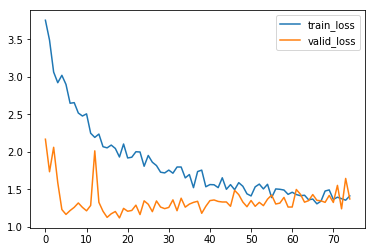

In [27]:
index = list(range(len(history['train'])))
plt.plot(index, history['train'], label='train_loss')
plt.plot(index, history['valid'], label='valid_loss')
plt.legend(loc=1)
plt.show()

In [31]:
im1, im2, label = next(iter(validloader))
if torch.cuda.is_available():
    im1 = im1.cuda()
    im2 = im2.cuda()
out1, out2 = model.forward(im1,im2)
predicted_label = F.pairwise_distance(out1, out2)

In [53]:
layer1 = model.layer1(im1)
layer2 = model.layer2(layer1)
layer3 = model.layer3(layer2)
layer4 = model.layer4(layer3)


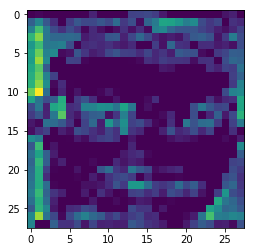

In [59]:
plt.imshow(layer2[0][32].cpu().detach())

In [144]:
def step(val, threshold=0.5):
    if val>threshold:
        return 1
    else:
        return 0
    

In [149]:
model.eval()
fn, fp, ap, an = 0,0,0,0
for idx, (img1,img2,label) in enumerate(validloader):
    if torch.cuda.is_available():
        img1 = img1.cuda()
        img2 = img2.cuda()
    out1, out2 = model.forward(img1,img2)
    predicted_label = F.pairwise_distance(out1, out2)
    
    for i in range(img1.size(0)):
        pr = step(predicted_label[i].item(), threshold=0.3)
        gt = int(label[i].item())
        
        if pr==False and gt==True: fn+=1
        elif pr==True and gt==True: ap+=1
        elif pr==False and gt==False: an+=1
        elif pr==True and gt==False: fp+=1
        
fn, fp, ap, an
error = (fn + fp) / (fp+fn+ap+an) * 100
accuracy = ap+an / (fp+fn+ap+an) * 100
accuracy, error

(75.33333333333333, 35.0)

In [113]:
1==True

True

Predicted: 1	 Ground Truth: 0.0


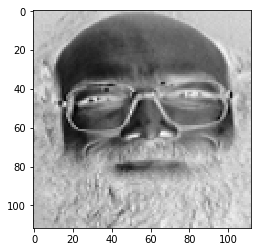

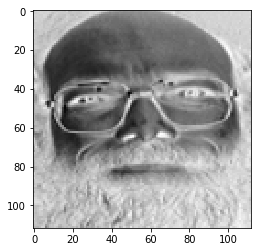

In [111]:
idx = 3
i1 = im1[idx]
i2 = im2[idx]
lbl = label[idx]
pl = threshold(predicted_label[idx].item())

print(f'Predicted: {pl}\t Ground Truth: {lbl.item()}')
plt.imshow(i1.squeeze().cpu(), cmap='gray');plt.show()
plt.imshow(i2.squeeze().cpu(), cmap='gray');plt.show()
